## Evacuation

For New Year's Eve, the police department of Milan expects a massive inflow of people to the Duomo Square around midnight.

It is expected that from midnight to 1 a.m. the people will leave the Square and reach the closest underground stations: Cordusio, San Babila, Missori, Montenapoleone, Cairoli, Cadorna, Lanza. It is also supposed that the people will take the shortest path to reach the underground. For safety reasons, access to the Duomo underground station will be restricted.

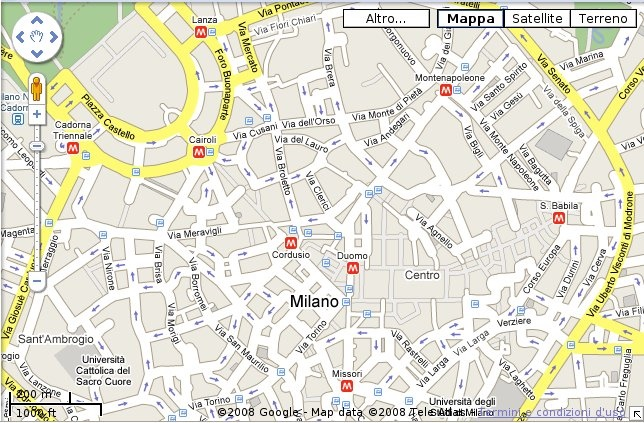

Consider the following, simplified, street map of Milan:

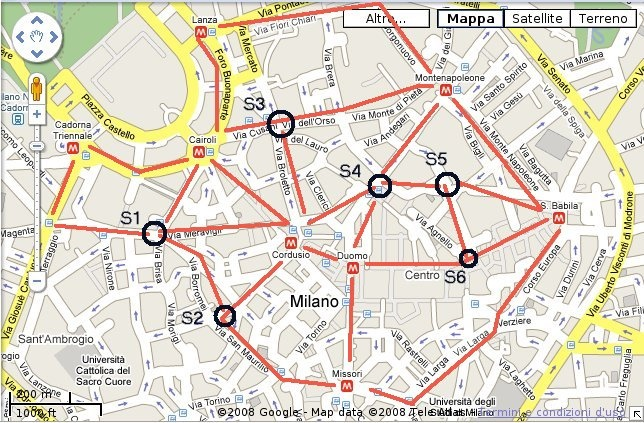


<div>
<img src="attachment:milano1.jpg" width="450"/>
</div>

In the following table, we report the expected traveling time (in fraction of hours) between
each pair of underground stations (including the Duomo one). Since the street map is itself
sparse, we also give the table in a sparse form.

| from            |-|to|-|
|-----------------|-|--|-|
| Duomo           | Cordusio: 0.2| Missori: 0.2| S4: 0.2|
| Cordusio        | S2: 0.2| S1: 0.225| Cairoli: 0.4|
| Missori         | San Babila: 0.2125| S5: 0.35|
| S6              | San Babila: 0.4| S5: 0.35| Duomo: 0.4|
| San Babila      | S5: 0.225| Montenapoleone: 0.6|
| S5              | S4: 0.2|
| S4              | Montenapoleone: 0.35| Cordusio: 0.25|
| Montenapoleone  | S3: 0.25| Lanza: 0.25|
| S3              | Cairoli: 0.05| Cordusio: 0.15|
| S2              | S1 : 0.0875|
| Lanza           | Cairoli: 0.2|
| Cairoli         | Cadorna : 0.2|
| S1              | Cadorna: 0.15|

Give a linear programming formulation for the problem of $\textbf{finding the shortest paths}$ from Duomo to any of the selected stations, so as to be able to suggest to the police department which routes will be, most likely, taken.

In [8]:
# When using Colab, make sure you run this instruction beforehand
#!pip install mip

 <h3 align="center">Formulation</h3>

- Sets
    - $V$: nodes
    - $T$: target nodes
    - $A \subseteq V \times V$: arcs
    
- Parameters
    - $s \in T$: root node
    - $c_{ij}$: cost for arc $(i,j)$, $(j,i) \in A$
    
- Variables
    - $x_{ij}$: quantity of flow on arc $(i,j)$, $(j,i) \in A$
    
- Model
$$
\begin{array}{lll}
  \min & \sum_{(i,j)\in A} c_{ij} x_{ij} \qquad & \text{(cost)}\\
  \textrm{s.t.} & \begin{equation}
       \sum_{(h,j)\in A} x_{hj} - \sum_{(i,h)\in A} x_{ih} =
        \begin{cases}
            |T| - 1 & \text{$h = s$} \\
            -1 & \text{$h \in T \setminus \{s\}$} \\
            0 & \text{$h \in V \setminus T$}
        \end{cases}
    \end{equation} & \text{(balance)} \\
  & x_{ij} \geq 0, \ \ (i,j) \in A & \text{(nonnegativity)}\\
\end{array}
$$

We formulate the problem as that of finding the subtree of shortest paths rooted in the Duomo station and reaching all the underground stations of interest, contained in the set $T$. A minimum cost flow formulation is used. I would have used a different formulation,based on the usage (or not) of the arcs


NOTE: We are using the auxiliary flow $x$ to find the shortest paths. Each shortest path is represented by 1 unit of flow starting from Duomo and reaching a station. The flow x does not model the actual flow of people: it is only used to formulate the shortest paths problem --> modellistic abstraction (strange, but typical).

In [9]:
from itertools import product
from sys import stdout as out
from mip import Model, xsum, minimize, BINARY
import json
import mip

'''
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Colab Notebooks/
'''


with open("evacuation.txt") as jsonFile:
    data = json.load(jsonFile)

In [10]:
# names of places to visit
V = data['V']
T = data['T']
s = 'Duomo'

E = set()
temp_c = {}
for j, i in enumerate(data['A']):
    E.add(tuple(i))
    temp_c[tuple(i)] = data['values'][j]

A = E.copy()
for arc in E:
    A.add((arc[1],arc[0]))

c = {}
for arc in temp_c:
    c[arc] = temp_c[arc]
    c[arc[1],arc[0]] = temp_c[arc]

b = {}
for i in V:
    if i == s:
        b[i] = len(T) - 1
    elif i in T:
        b[i] = -1
    else:
        b[i] = 0

In [11]:
model = Model()

# variables indicating the quantity of flow on arc (i,j)
x = {(i, j): model.add_var() for (i, j) in A}

# Alternative: --> that is a better model, in my opinion, easier to understand and work with
# variables indicating if arc (i,j) is used on the route or not
#x = [model.add_var(name = str(arc[0])+','+str(arc[1]), lb=0) for arc in A]

In [12]:
# objective function: minimize the cost
model.objective = mip.minimize(mip.xsum(c[i, j]* x[i, j] for (i, j) in A))

# Alternative:
# objective function: minimize the distance
#model.objective = minimize(xsum(c[arc]*x[i] for i,arc in enumerate(A)))

In [13]:
# balance constraint --> entering flow = exiting flow
for i in V:
  model.add_constr(mip.xsum(x[i, j] for j in V if (i, j) in A and i != j) - mip.xsum(x[j, i] for j in V if (j, i) in A and i != j)  == b[i])

# Alternative
# balance constraint
#for i in V:
    #model += xsum(x[j] for j,_ in enumerate(A) if x[j].name.split(',')[0] == i) - xsum(x[j] for j,_ in enumerate(A) if x[j].name.split(',')[1] == i) == b[i]

In [14]:
# optimizing
model.optimize()

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 28 2021 

Starting solution of the Linear programming problem using Dual Simplex



<OptimizationStatus.OPTIMAL: 0>

In [16]:
for i in model.vars:
    if i.x != 0:
        print(i.name, i.x)

var(3) 1.0
var(7) 4.0
var(9) 1.0
var(17) 1.0
var(20) 2.0
var(27) 1.0
var(31) 1.0
var(39) 2.0
var(40) 1.0
var(42) 2.0


In [17]:
model.objective.x

2.9374999999999996